Predict the age of abalone from physical measurements

In [56]:
from ucimlrepo import fetch_ucirepo 

#определение моделей
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest

import numpy as np
import seaborn as sns

abalone = fetch_ucirepo(id=1) 

# изменение нечисловых значений пола
abalone.data.original.loc[abalone.data.original['Sex'] == 'M', abalone.data.original.columns == 'Sex'] = 1
abalone.data.original.loc[abalone.data.original['Sex'] == 'F', abalone.data.original.columns == 'Sex'] = 2
abalone.data.original.loc[abalone.data.original['Sex'] == 'I', abalone.data.original.columns == 'Sex'] = 3

data_abalone = abalone.data.original
features = abalone.data.features.columns

#вытащить матрицы
X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

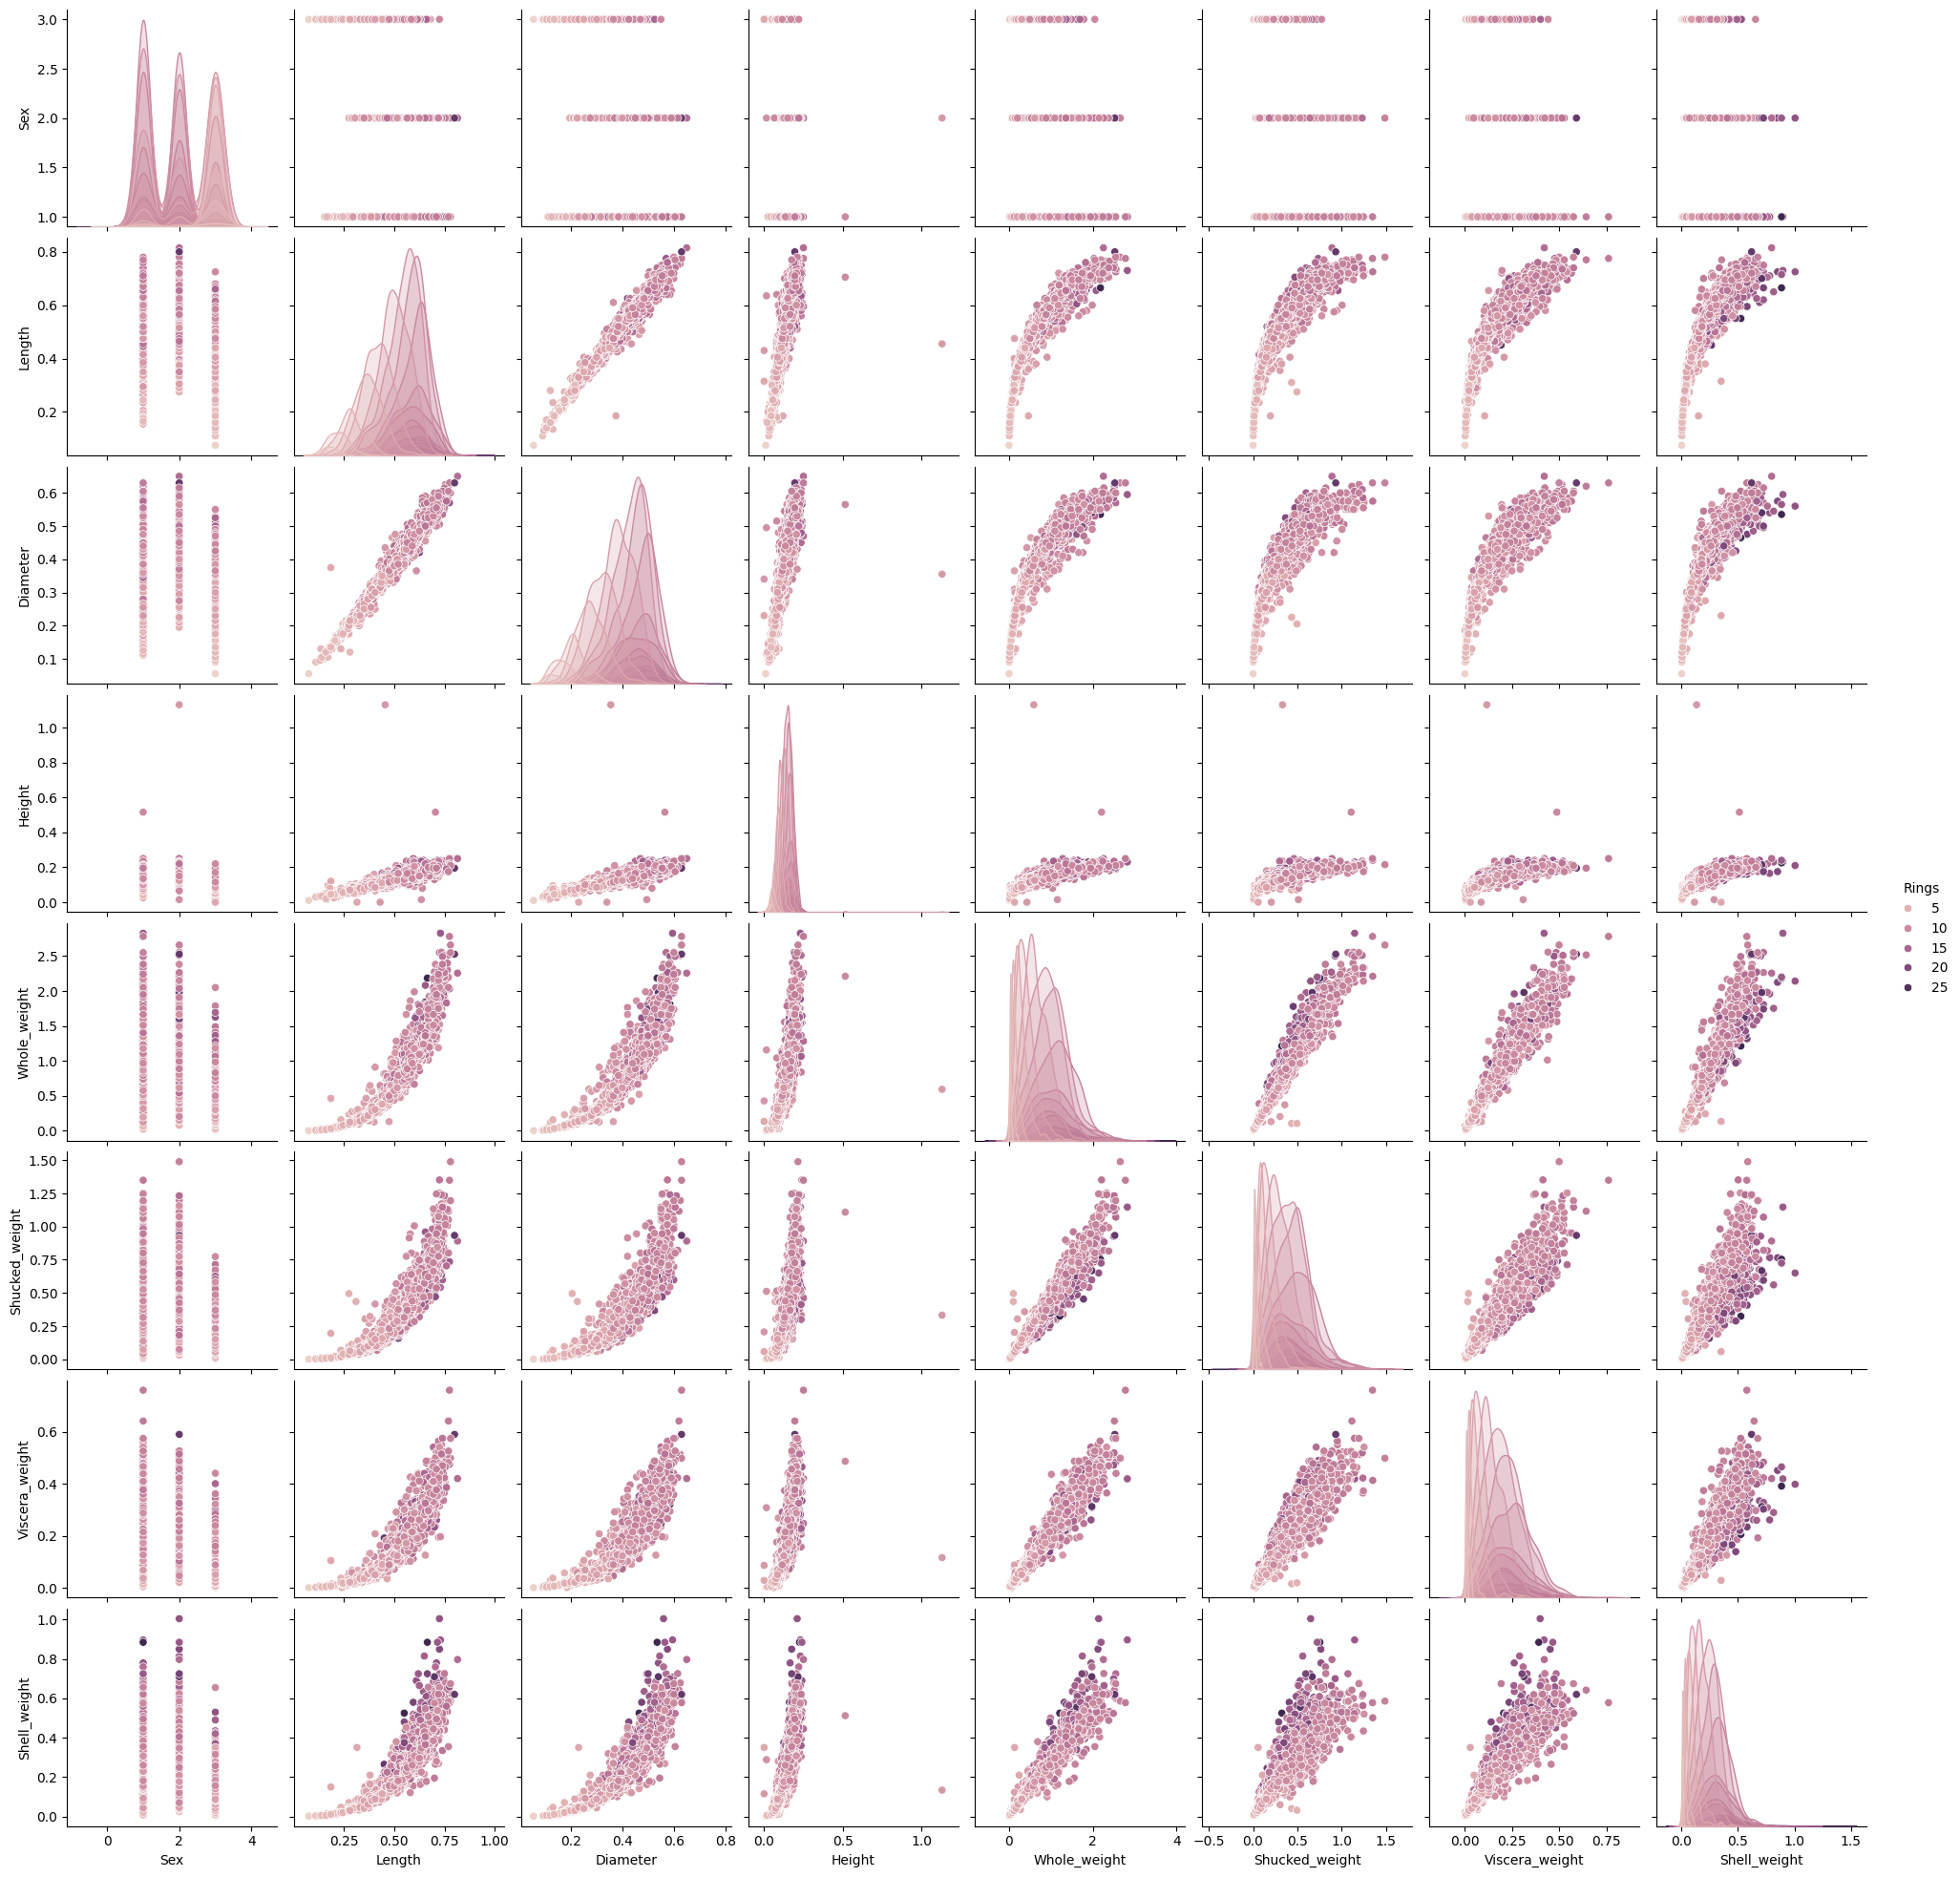

In [44]:
# построение графика зависимостей
sns.pairplot(data=data_abalone, hue='Rings')

In [58]:
#выборка по фичам
new_X = SelectKBest(k = 5).fit(X, y).get_feature_names_out(input_features = features)
print(new_X)

data_abalone = data_abalone[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shell_weight', 'Rings']]

['Length' 'Diameter' 'Height' 'Whole_weight' 'Shell_weight']


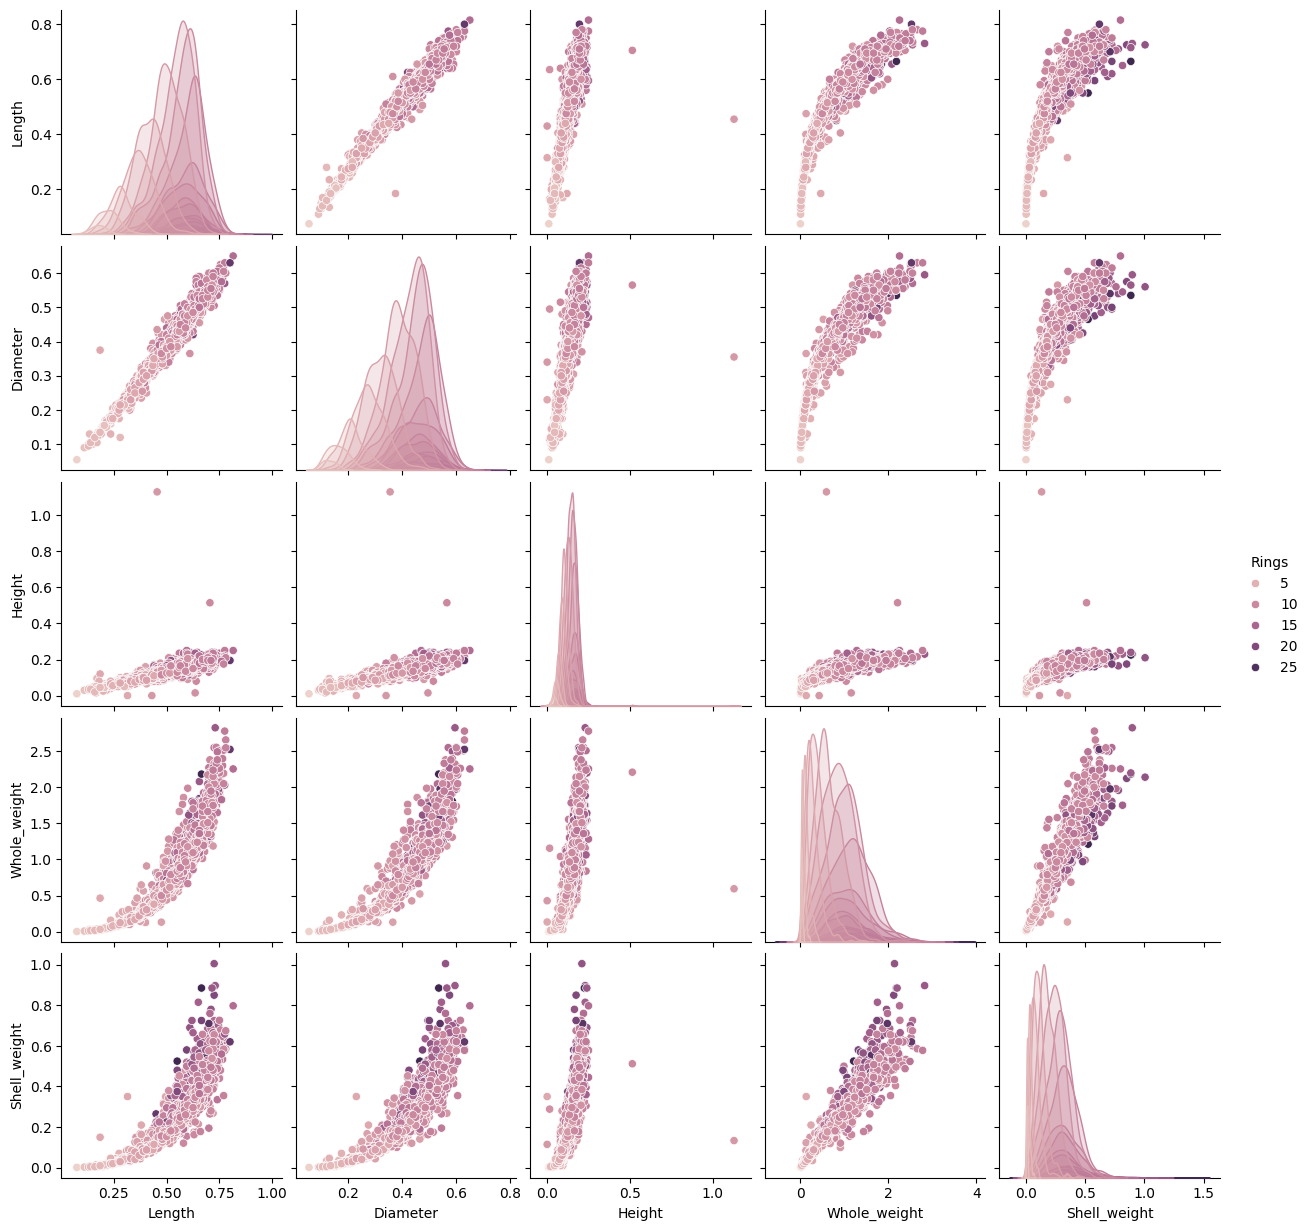

In [54]:
#отображение укороченных параметров
sns.pairplot(data=data_abalone, hue='Rings')

In [60]:
#отделение таргета
trg = data_abalone[['Rings']]
trn = data_abalone.drop(['Rings'], axis = 1)

#определение моделей
models = [
    LinearRegression()
]

y_train, y_test, X_train, X_test = train_test_split(trg, trn, test_size = 0.4)
print(X_train, X_test, y_train, y_test)

      Length  Diameter  Height  Whole_weight  Shell_weight
3316   0.440     0.350   0.140        0.4510        0.1840
2425   0.575     0.450   0.170        0.9315        0.2600
1691   0.625     0.470   0.155        1.1955        0.3145
1752   0.710     0.560   0.220        2.0150        0.5660
704    0.400     0.300   0.125        0.4170        0.1175
...      ...       ...     ...           ...           ...
3458   0.610     0.470   0.160        1.0745        0.2900
3775   0.580     0.450   0.155        0.8275        0.2445
2842   0.600     0.475   0.175        1.1100        0.2850
2205   0.275     0.220   0.080        0.1365        0.0420
1775   0.485     0.365   0.105        0.5205        0.1820

[2506 rows x 5 columns]       Length  Diameter  Height  Whole_weight  Shell_weight
2393   0.300     0.220   0.090        0.1425        0.0430
142    0.650     0.520   0.190        1.3445        0.4465
1069   0.375     0.280   0.080        0.2345        0.0670
2187   0.495     0.385   0.135 